# Submit for EXPR

## imports & load data

In [1]:
import os
import pickle
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [2]:
data_dir = 'fea_notebooks/features_newvf2.pickle'
test_dir = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER/test_set/CVPR_5th_ABAW_EXPR_test_set_sample.txt'
cropped_data = '/home/avsavchenko/src/emotions-multimodal/faces/ABAW/abaw5/enet_b0_8_best_vgaf_cropped.pickle'

In [3]:
with open(data_dir, 'rb') as handle:
    data=pickle.load(handle)
print(len(data))

2941546


In [4]:
print(f"Torch: {torch.__version__}")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Torch: 2.0.1+cu118
cuda:0


## load model & dataloader

In [5]:
from tcn import TemporalConvNet
from trans_encoder import TransEncoder


class Model(nn.Module):
    def __init__(self, modality=['frames', 'w2v2large', 'openl3', 'w2v2hub'],
                 embedding_dim={'frames': 1280, 'w2v2large': 1024, 'openl3': 512,
                                'w2v2hub': 256},
                 tcn_channel={
                     'frames': [1280, 512, 256, 128],
                     'w2v2large': [1024, 512, 256, 128],
                     'openl3': [512, 256, 128],
                     'w2v2hub': [256, 128]
    }):
        super(Model, self).__init__()
        self.modality = modality

        self.temporal, self.fusion = nn.ModuleDict(), None

        for modal in self.modality:
            self.temporal[modal] = TemporalConvNet(num_inputs=embedding_dim[modal],
                                                   num_channels=tcn_channel[modal], dropout=0.3, attention=False)

        conv_dim = 0
        for m in self.modality:
            conv_dim += tcn_channel[m][-1]
            
        self.encoder = TransEncoder(
            inc=conv_dim, outc=256, dropout=0.3, nheads=4, 
            nlayer=8)
            
        self.head = nn.Sequential(
            nn.Linear(256, 256//2),
            nn.BatchNorm1d(256//2),
            nn.Linear(256//2, 8),
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        bs, seq_len, _ = x[self.modality[0]].shape
#         print(bs, seq_len)
        for m in self.modality:
            x[m] = x[m].transpose(1, 2)
            x[m] = self.temporal[m](x[m])

        feat_list = []
        for m in self.modality:
            feat_list.append(x[m])
        out = torch.cat(feat_list, dim=1)
        out = self.encoder(out)

        out = torch.transpose(out, 1, 0)
        out = torch.reshape(out, (bs*seq_len, -1))
#         print(out.shape)

        out = self.head(out)
        return self.softmax(out)

model = Model()
model.to(device);
model.load_state_dict(torch.load('42f1.pt'))

<All keys matched successfully>

In [6]:
from math import ceil


class audioDataset(Dataset):
    def __init__(self, names, values, window=300, step=200):
        self.data = values
        self.lenghts_of_seq = len(self.data[0])
#         self.y = y
        
        self.names = names
        self.window = window
        self.step = step
        
        self.len = ceil((self.lenghts_of_seq - self.window) / self.step) + 1
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if idx == self.len-1:
            stride = [torch.tensor(i[-self.window::]) for i in self.data]
#             y = self.y[-self.window::]
        
        else:
            stride = [torch.tensor(i[idx*self.step:idx*self.step + self.window]) for i in self.data]
#             y = self.y[idx*self.step:idx*self.step + self.window]
            
        r_dict = dict([(i, j.to(device)) for i, j in zip(self.names, stride)])
        
        return r_dict, len(self.data[0])

## Smoothing on validation

In [7]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations'

In [8]:
def predict(data, model):
    pred_labels_val = []
#     predicts = []

    a_dataset = audioDataset(['frames', 'w2v2large', 'openl3', 'w2v2hub'],
                     data, window=300, step=300)
    training_loader = DataLoader(a_dataset, batch_size=64, shuffle=False)

    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(training_loader):
            vinputs, d_len = vdata
            voutputs = model(vinputs)
            pred_labels_val += voutputs.data.tolist()
    
    d_len = d_len[0]
    s = 300 - len(pred_labels_val) + d_len
    return pred_labels_val[:-300]+pred_labels_val[-s:]

In [9]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,expressions=[],[],[]
        w2v2large_t, openl3_t, w2v2hub_t = [], [], []
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+str(i).zfill(5)+'.jpg'
                    if imagename in data:
                        X.append(data[imagename]['frame'][0])
                        w2v2large_t.append(data[imagename]['w2v2large']) 
                        openl3_t.append(data[imagename]['openl3']) 
                        w2v2hub_t.append(data[imagename]['w2v2hub'])
                        
                        indices.append(i)
                        expressions.append(int(line))
                        
        test_videos[fn]=(predict([X, w2v2large_t, openl3_t, w2v2hub_t], model),indices,np.array(expressions))
print(len(test_videos))

  0%|          | 0/70 [00:00<?, ?it/s]<ipython-input-6-786bd96cdc3b>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  stride = [torch.tensor(i[idx*self.step:idx*self.step + self.window]) for i in self.data]
100%|██████████| 70/70 [02:11<00:00,  1.88s/it]

70


In [10]:
deltas=[0,15,20, 25, 30, 35, 40,45]
# deltas=[0,5,15,25,50,75,100,150,200,500]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions) in test_videos.items():
    for i,ind in enumerate(indices):
        if int(expressions[i])>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
#     print(indices[-1])
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                y_pred_expr = np.array(y_pred_expr)
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            best_ind=np.argmax(proba)
            best_ind_no_other=np.argmax(proba[:7])
            if best_ind==7 and proba[best_ind]-proba[best_ind_no_other]<0.05:
                best_ind=best_ind_no_other
            preds.append(best_ind)
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.5483987431590461 F1: 0.42844366975419507
15 Acc: 0.5498393202477936 F1: 0.4299144416727223
20 Acc: 0.5512691734376173 F1: 0.431087329265716
25 Acc: 0.5517696220540556 F1: 0.4309989917164526
30 Acc: 0.5524773993830183 F1: 0.43168839241965895
35 Acc: 0.5522664960375193 F1: 0.43129849564367645
40 Acc: 0.5516051889372259 F1: 0.4307812769025995
45 Acc: 0.5514371811874216 F1: 0.4300327480084029


In [11]:
hyperparams=[(isMean,delta) for delta in [0,2,7]  for isMean in [1,0] if not (isMean==0 and delta==0)]
total_true=[]
total_preds=[[] for _ in range(len(hyperparams))]
for videoname,(y_pred_expr,indices,expressions) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                y_pred_expr = np.array(y_pred_expr)
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,(isMean,delta) in enumerate(hyperparams):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            if isMean:
                proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            else:
                proba=np.median(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,(isMean,delta) in enumerate(hyperparams):
    preds=np.array(total_preds[hInd])
    print('mean' if isMean else 'median',delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

mean 0 Acc: 0.5484416387547408 F1: 0.42846120775103336
mean 2 Acc: 0.5487883781532731 F1: 0.4289087949779827
median 2 Acc: 0.5486668406321381 F1: 0.4287485799380695
mean 7 Acc: 0.5493674686951517 F1: 0.42910770986553437
median 7 Acc: 0.5492638043388895 F1: 0.42889385173379246


In [12]:
#deltas=[0,1,5,7,15]
deltas=[0,15,20, 25, 30, 35, 40,45,50,55,60,65,70,75,80,85,90]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                y_pred_expr = np.array(y_pred_expr)
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.5484416387547408 F1: 0.42846120775103336
15 Acc: 0.5506686350978913 F1: 0.4304197840597356
20 Acc: 0.5521628316812571 F1: 0.4314224594852984
25 Acc: 0.552942101669711 F1: 0.43160571407663273
30 Acc: 0.5538214613814526 F1: 0.4322303685168968
35 Acc: 0.5532352215736249 F1: 0.430942352912059
40 Acc: 0.5531744528130574 F1: 0.43149080451768795
45 Acc: 0.5527633700209831 F1: 0.4307355426709346
50 Acc: 0.5535390653764625 F1: 0.4316479979134312
55 Acc: 0.5545363879763645 F1: 0.43222903753093667
60 Acc: 0.5547723137526854 F1: 0.4324242180178791
65 Acc: 0.5546900971942705 F1: 0.4311181006817163
70 Acc: 0.5551941204436834 F1: 0.4314455983758668
75 Acc: 0.5548116347154056 F1: 0.43132646500628846
80 Acc: 0.5538429091793 F1: 0.43074730319870125
85 Acc: 0.5529385270367365 F1: 0.42990812108677023
90 Acc: 0.5531422811162864 F1: 0.42994404828231425


(279749,) (279749,) 0.5538214613814526


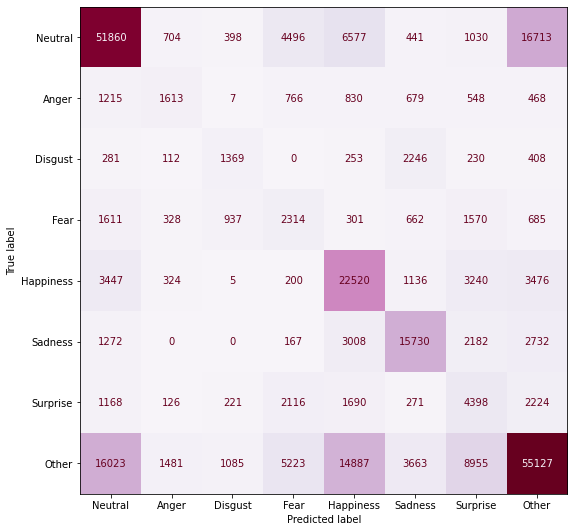

In [14]:
labels=['Neutral', 'Anger', 'Disgust', 'Fear', 
           'Happiness', 'Sadness', 'Surprise', 'Other']
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='PuRd', colorbar=False)
    plt.tight_layout()
    plt.show()

plt_conf_matrix(total_true,np.array(total_preds[4]),labels);

## test predict

In [7]:
test_set = []

def get_names(dirname):
    
    names = []
    with open(os.path.join(dirname)) as f:
        lines = f.read().splitlines()
        
        for i,line in enumerate(lines):
            if i>0:
                name = line[:-1]
                names.append(name)
                
    print(len(names))
    return names

test_set = get_names(test_dir)

1022655


In [8]:
keys = data.keys()
c = 0
missed = []

for k in test_set:
    if k in keys:
        c+=1
        
    else:
        missed.append(k)
        
c

1007648

In [9]:
with open(os.path.join(test_dir),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s[:-1].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

1022656 ['image_location,Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise,Other', '14-30-1920x1080/00001.jpg,', '14-30-1920x1080/00002.jpg,', '14-30-1920x1080/00003.jpg,', '14-30-1920x1080/00004.jpg,']
228


In [10]:
datasets = {}
for k in tqdm(test_set_videos.keys()):
    w2v2large_t, openl3_t, w2v2hub_t = [], [], []
    X_t = []
    for images in test_set_videos[k]:
        key = f'{k}/{images}'
        if key in missed: continue
        X_t.append(data[key]['frame'][0])
        w2v2large_t.append(data[key]['w2v2large'])
        openl3_t.append(data[key]['openl3'])
        w2v2hub_t.append(data[key]['w2v2hub'])
    
    a_dataset = audioDataset(['frames', 'w2v2large', 'openl3', 'w2v2hub'],
                     [X_t, w2v2large_t, openl3_t, w2v2hub_t], window=300, step=300)
    training_loader = DataLoader(a_dataset, batch_size=64, shuffle=False)
    datasets[k] = training_loader

100%|██████████| 228/228 [02:20<00:00,  1.63it/s]


In [11]:
def predict(loader, model):
    pred_labels_val = []
#     predicts = []

    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(loader):
            vinputs, d_len = vdata
            voutputs = model(vinputs)
            pred_labels_val += voutputs.data.tolist()
    
    d_len = d_len[0]
    s = 300 - len(pred_labels_val) + d_len
    return pred_labels_val[:-300]+pred_labels_val[-s:]

In [12]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames,scores=[],[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in data:
            indices.append(int(img_name[:-4]))
#             print()
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    test_videos[videoname]=(predict(datasets[videoname], model),indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
    
print(len(test_videos))

  0%|          | 0/228 [00:00<?, ?it/s]<ipython-input-6-786bd96cdc3b>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  stride = [torch.tensor(i[idx*self.step:idx*self.step + self.window]) for i in self.data]
100%|██████████| 228/228 [04:52<00:00,  1.28s/it]

228


In [17]:
delta = 30
with open(os.path.join('predictions_expr_tcn.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames) in test_videos.items():
        cur_ind=0
        preds_proba=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_expr[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_expr[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    y_pred_expr = np.array(y_pred_expr)
                    pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_expr[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')